<a href="https://colab.research.google.com/github/Prabhsimran1313/CVD_Disease_Prediction_using_ML/blob/main/CVD__Disease_Prediction_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [ ]:
!pip install kmodes
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from kmodes.kmodes import KModes
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading the data

In [ ]:
# read the data and show first 5 rows
df = pd.read_csv("/content/drive/MyDrive/Datasets ML/cardio_train.csv",sep=";")
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### Initial Inspection

In [ ]:
print(df.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [ ]:
#drop id
df = df.drop('id', axis=1)


### Exploratory Data Analysis (EDA)

Cardio Class Counts:
 cardio
0    35021
1    34979
Name: count, dtype: int64


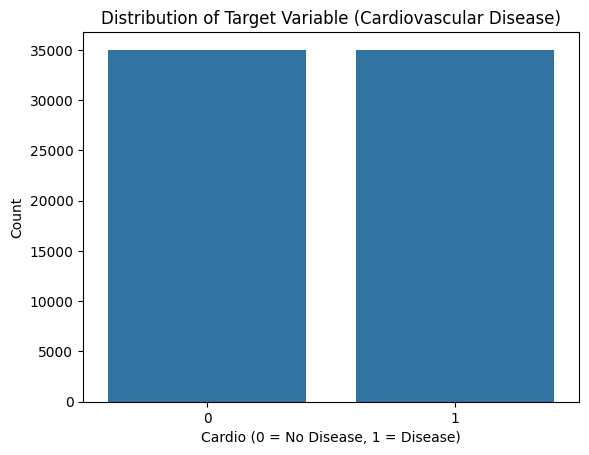

In [ ]:
# Count the number of samples per class
cardio_counts = df['cardio'].value_counts()
print("Cardio Class Counts:\n", cardio_counts)
# Plot the class distribution
sns.countplot(x='cardio', data=df)
plt.title('Distribution of Target Variable (Cardiovascular Disease)')
plt.xlabel('Cardio (0 = No Disease, 1 = Disease)')
plt.ylabel('Count')
plt.show()


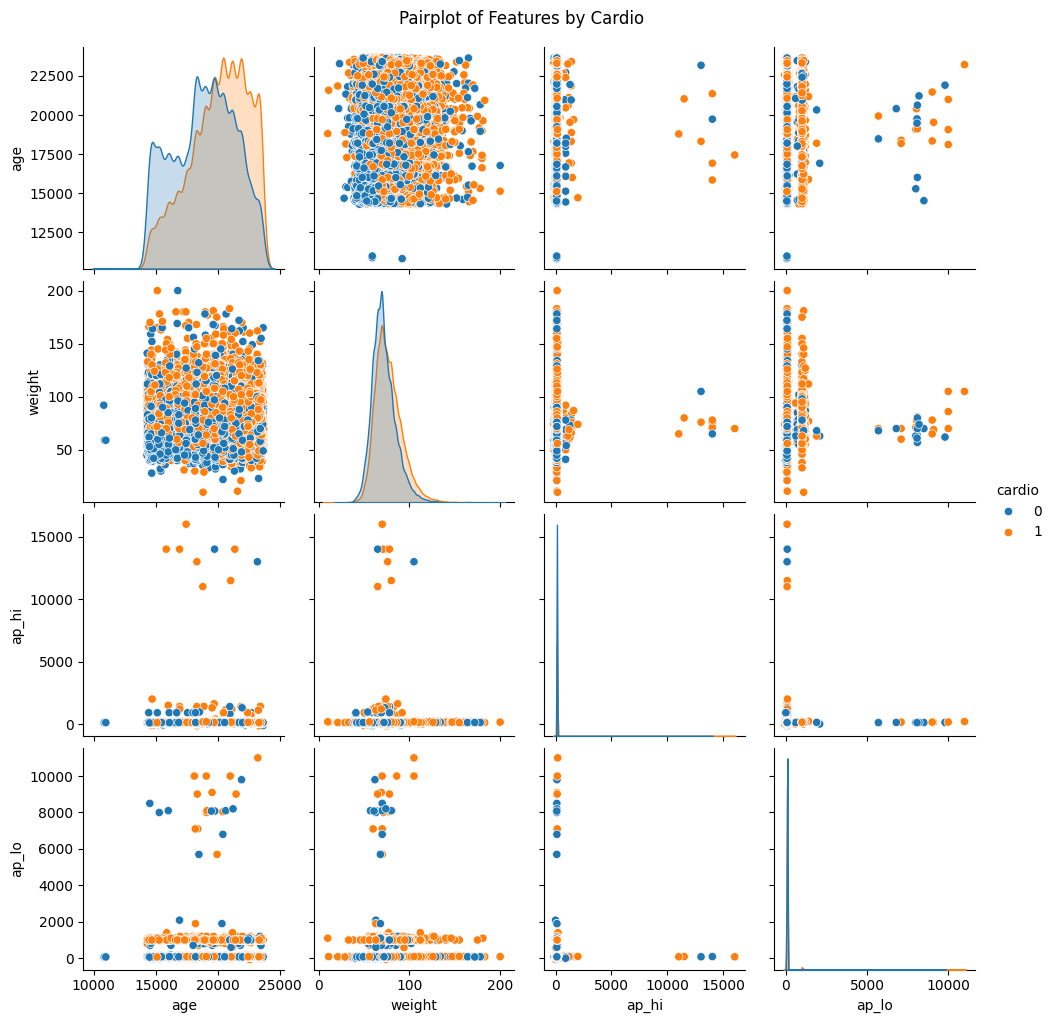

In [ ]:
# Pairplot of selected features against target
sns.pairplot(df[['age', 'weight', 'ap_hi', 'ap_lo', 'cardio']], hue='cardio')
plt.suptitle("Pairplot of Features by Cardio", y=1.02)
plt.show()

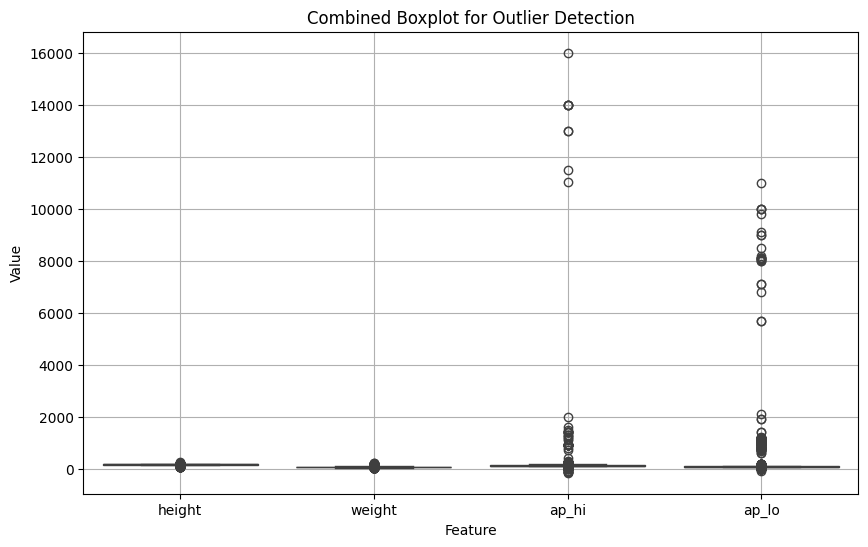

In [ ]:
# Select relevant columns
outlier_cols = ['height', 'weight', 'ap_hi', 'ap_lo']

# Melt the DataFrame to long format
df_melted = df[outlier_cols].melt(var_name='Feature', value_name='Value')

# Create a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature', y='Value', data=df_melted)
plt.title('Combined Boxplot for Outlier Detection')
plt.grid(True)
plt.show()

### Removing Outliers

In [ ]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
len(df)

60142

In [ ]:
df[df['ap_lo']> df['ap_hi']].shape[0] # To check number of cases where diastolic pressure is higher than systolic?

0

In [ ]:
# After removing outliers
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Feature Engineering

In [ ]:
df['age'] = (df['age'] / 365).round().astype('int')  # Transformation: Converting age from days to years
print(df.head())

   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   52       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
4   48       1     156    56.0    100     60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  


In [ ]:
# Categorizing features
# # Define the bin edges and labels
age_edges = [30, 35, 40, 45, 50, 55, 60, 65]
age_labels = [0, 1, 2, 3, 4, 5, 6]

#  bin in  5 years span
df['age_group'] = pd.cut(df['age'], bins=7, labels=range(7), include_lowest=True,right=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3


In [ ]:
df['bmi'] = df['weight']/((df['height']/100)**2)
df.head()

bmiMin = int(df['bmi'].min())
bmiMax = int(df['bmi'].max())

print(bmiMin, bmiMax)

df['bmi'] = pd.cut(df['bmi'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()


df["bmi"].value_counts(normalize=True)

16 46


,proportion
bmi,
1,0.461325
2,0.330202
3,0.133068
0,0.038193
4,0.033554
5,0.003658


In [ ]:
df['map'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

mapMin = int(df['map'].min())
mapMax = int(df['map'].max())

print(mapMin, mapMax)

df['map'] = pd.cut(df['map'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()

73 121


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4,3,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3,2,5
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3,1,0


In [ ]:
null_rows = df[df.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio, age_group, bmi, map]
Index: []


In [ ]:
# Drop features We only need categorical data
df_og=df

df=df.drop(['height','weight','ap_hi','ap_lo','age'],axis=1)

df.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,2,1,1,0,0,1,0,3,1,2
1,1,3,1,0,0,1,1,4,3,4
2,1,3,1,0,0,0,1,4,1,2
3,2,1,1,0,0,1,1,3,2,5
4,1,1,1,0,0,0,0,3,1,0


### Encoding

In [ ]:
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)
df.describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,0.347311,0.350953,0.220229,0.085631,0.051877,0.803648,0.488228,4.042233,1.673440,2.359449
std,0.476120,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866,1.377070,0.898707,1.186906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,2.000000,2.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,2.000000,3.000000
max,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000


### Clustering (KModes)

In [ ]:
cost = []
num_clusters = range(1,6) # 1 to 5
for i in list(num_clusters):
    kmode = KModes(n_clusters=i, init = "Huang", n_init = 5, verbose=0,random_state=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)

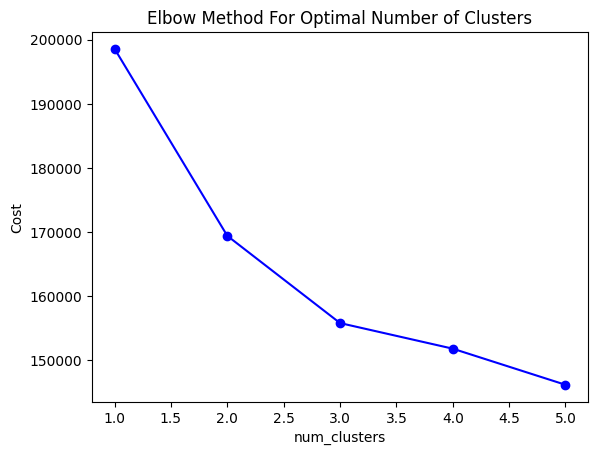

In [ ]:
# Clusters graph
plt.plot(num_clusters, cost, 'bo-')
plt.xlabel('num_clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [ ]:
# Building KModes model
km = KModes(n_clusters=2, init = "Huang", n_init = 5,random_state=1)
clusters = km.fit_predict(df)
clusters

array([0, 1, 0, ..., 0, 1, 0], dtype=uint16)

In [ ]:
# Adding clusters column in DF
df.insert(0,"clusters",clusters,True)
df.head()

,clusters,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,0,1,0,0,0,0,1,0,3,1,2
1,1,0,2,0,0,0,1,1,4,3,4
2,0,0,2,0,0,0,0,1,4,1,2
3,1,1,0,0,0,0,1,1,3,2,5
4,0,0,0,0,0,0,0,0,3,1,0


### Cluster-Based Visualizations

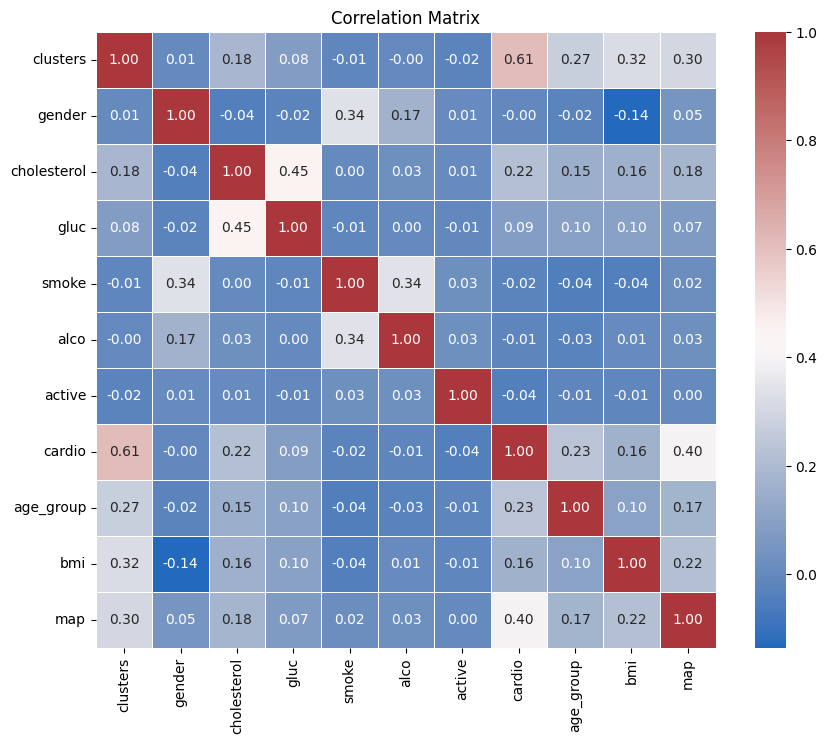

In [ ]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
# Draw correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='vlag', fmt=".2f", linewidths=.5)
# Show the figure
plt.title('Correlation Matrix')
plt.show()

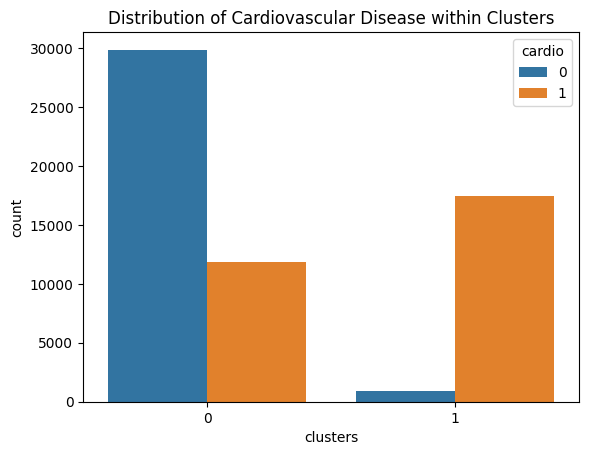

In [ ]:
# Distribution of cardio in clusters
sns.countplot(x='clusters', hue='cardio', data=df)
plt.title('Distribution of Cardiovascular Disease within Clusters')
plt.show()

In [ ]:
x = df.drop(['cardio','gender','alco'], axis=1)
y = df['cardio']

x.head()

,clusters,cholesterol,gluc,smoke,active,age_group,bmi,map
0,0,0,0,0,1,3,1,2
1,1,2,0,0,1,4,3,4
2,0,2,0,0,0,4,1,2
3,1,0,0,0,1,3,2,5
4,0,0,0,0,0,3,1,0


### Train-Test Split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=1)

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48113 entries, 20655 to 38356
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clusters     48113 non-null  uint16
 1   cholesterol  48113 non-null  int64 
 2   gluc         48113 non-null  int64 
 3   smoke        48113 non-null  int64 
 4   active       48113 non-null  int64 
 5   age_group    48113 non-null  int64 
 6   bmi          48113 non-null  int64 
 7   map          48113 non-null  int64 
dtypes: int64(7), uint16(1)
memory usage: 3.0 MB


### Model training

### Random Forest

In [ ]:
from sklearn.metrics import accuracy_score
rfModel = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=1
)

# Train the model
rfModel.fit(x_train, y_train)

# Predict on test data
rf_pred = rfModel.predict(x_test)
# Accuracy
rf_accuracy = accuracy_score(y_test, rf_pred) * 100
print(f"Random Forest Accuracy: {rf_accuracy:.2f}%")


Random Forest Accuracy: 85.34%


### Performance Evaluation – Random Forest

In [ ]:
classification_report_str = classification_report(y_test, rf_pred, digits=4)

print("Classification Report for RF:\n", classification_report_str)

Classification Report for RF:
               precision    recall  f1-score   support

           0     0.8382    0.8879    0.8624      6220
           1     0.8719    0.8165    0.8433      5809

    accuracy                         0.8534     12029
   macro avg     0.8550    0.8522    0.8528     12029
weighted avg     0.8545    0.8534    0.8531     12029



Text(0.5, 427.9555555555555, 'Predicted label')

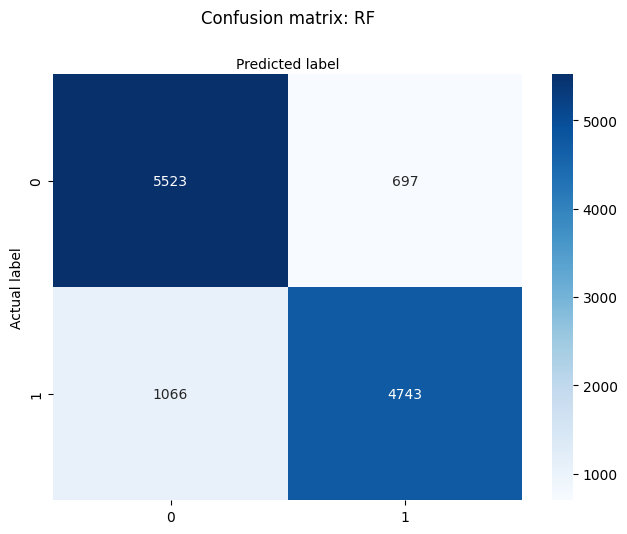

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, rf_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: RF', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

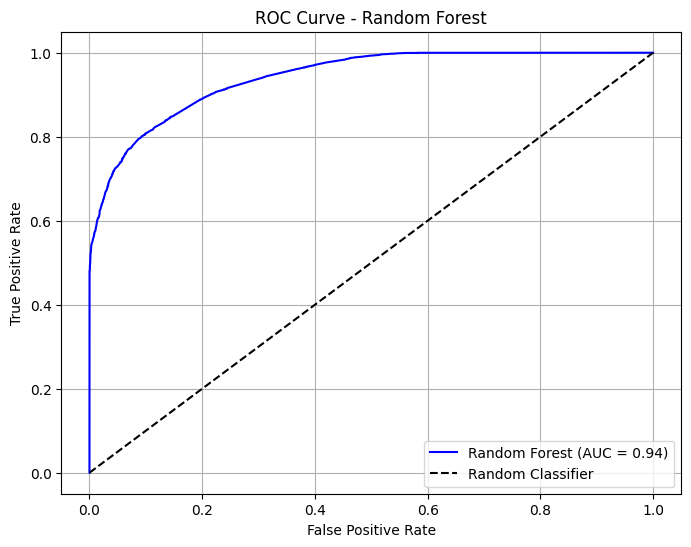

In [ ]:
# Get predicted probabilities for positive class (1)
rf_probs = rfModel.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC score
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_rf = roc_auc_score(y_test, rf_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### ANN Model

In [ ]:
# Define ANN architecture
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Use early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8479 - loss: 0.3043 - val_accuracy: 0.8542 - val_loss: 0.2938
Epoch 2/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8535 - loss: 0.2974 - val_accuracy: 0.8553 - val_loss: 0.2894
Epoch 3/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8541 - loss: 0.2970 - val_accuracy: 0.8552 - val_loss: 0.2883
Epoch 4/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8521 - loss: 0.2994 - val_accuracy: 0.8560 - val_loss: 0.2887
Epoch 5/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8494 - loss: 0.3036 - val_accuracy: 0.8561 - val_loss: 0.2875
Epoch 6/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8517 - loss: 0.3008 - val_accuracy: 0.8562 - val_loss: 0.2866
Epoch 7/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8554 - loss: 0.2955 - val_accuracy: 0.8561 - val_loss: 0.2895
Epoch 8/100
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8503 - loss: 0

In [ ]:
# Predict on test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Accuracy
ann_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"ANN Accuracy: {ann_accuracy:.2f}%")

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ANN Accuracy: 85.75%


### Performance Evaluation – ANN

In [ ]:
# Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      6220
           1       0.88      0.82      0.85      5809

    accuracy                           0.86     12029
   macro avg       0.86      0.86      0.86     12029
weighted avg       0.86      0.86      0.86     12029



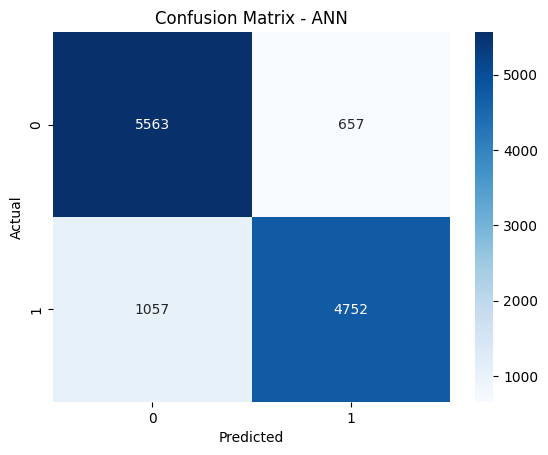

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

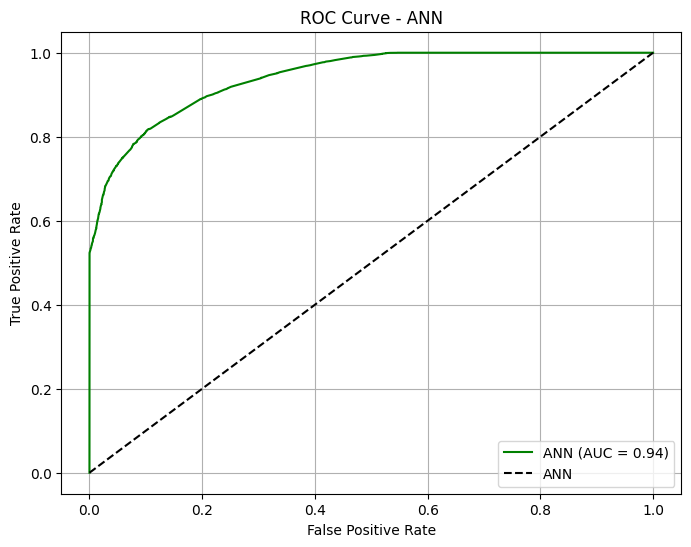

In [ ]:
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_prob)
auc_ann = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f"ANN (AUC = {auc_ann:.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='ANN')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ANN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Performance Comparison

In [ ]:
print(f"Random Forest Accuracy: {rf_accuracy:.2f}% | AUC: {auc_rf:.2f}")
print(f"ANN Accuracy: {ann_accuracy:.2f}%       | AUC: {auc_ann:.2f}")

Random Forest Accuracy: 85.34% | AUC: 0.94
ANN Accuracy: 85.75%       | AUC: 0.94


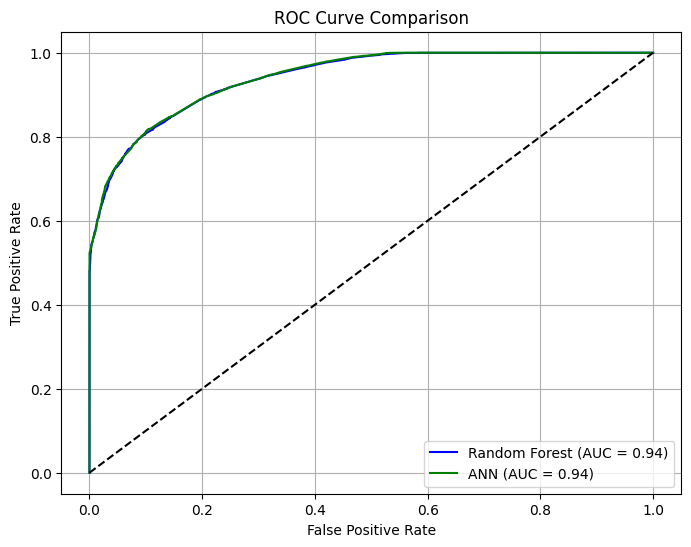

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='blue')
plt.plot(fpr_ann, tpr_ann, label=f"ANN (AUC = {auc_ann:.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
